In [1]:
from urllib import request
import zipfile
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import mean_squared_error

In [2]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### 2. Prepare error metrics: RMSE
Your Task:
1. Prepare 2 functions that will calculate the goodness of fit: RMSE and HR@n
2. RMSE:
$RMSE(R,\hat{R})=\sqrt{1/n \sum{(r - \hat{r})^2}}$ <br/>
$n\  - \text{# ratings in Y}$ <br/>
$R\  - \text{ground true ratings}$ <br/>
$\hat{R}\ - \text{predictions of your model}$ <br/>

In [8]:
def rmse(R,R_hat,index):
    """
    Calculates RMSE between true ratings R and ratings estimations R_hat for index.
    params:
         R (np.array): rank 2 matrix of (ground) true ratings
         R_hat (np.array): rank 2 matrix of ratings' predictions R.shape = R_hat.shape
         index (np.array): index of R and R_hat for which RMSE needs to be calculated
    returns:
         RMSE value
        
    """
    #YOUR TASK: implement RMSE
    X = np.multiply((R-R_hat), index)
    Y = np.sum(np.multiply(X,X))
    Z= np.sum(index)
    return np.sqrt(Y / Z)

### 3. Prepare error metrics HR@n (please solve after you implement MF with ALS)

Your task: write a function that calculates HR@n

HR(u)@n for a single user u is calculated when the number of recommended items for that user is n. If out of n recommended items m (m<=n) were consumed by user then:

#### $HR@n(u) = \frac{m}{n}$ <br/>

Overall HR@n is just an average over all users:
#### $HR@n = \frac{1}{n_u} \sum{\frac{m}{n}}$ <br/>
 
be careful with caveats with HR!

In [9]:
def HR_at_n(R,R_hat,R_exclude,n=10):
    """
    Calculates RMSE between true ratings R and ratings estimations R_hat for index.
    params:
         R (np.array): rank 2 matrix of (ground) true ratings
         R_hat (np.array): rank 2 matrix of ratings' predictions R.shape = R_hat.shape
         R_exclude (np.array): rank 2 matrix of ratings to be excluded i.e. if R_exclude[u,i]>0 then item i for user u has to be excluded from HR calculation (e.g. it was used for training)
         n (int): length of recommendation
    returns:
         RMSE value
        
    """
    #YOUR TASK: implement HR@n function
    R_hat = copy.copy(R_hat)
    exclude_items_per_user =  np.sum(R_exclude>0,axis=1)
    R_hat[R_exclude>0] = -np.inf
    pred_items = np.argsort(-R_hat,axis=1)
    true_items = np.argsort(-R,axis=1)
    exclude_items_cnt = np.sum(R_exclude>0,axis=1)
    test_items_cnt = np.sum(R>0,axis=1)
    hr_total = 0
    for user_id in range(pred_items.shape[0]):
            min_end = min(n,pred_items.shape[1]-exclude_items_cnt[user_id])
            pred_items_for_user = pred_items[user_id,:min_end]
            propper_itemscnt_for_user = np.sum(np.in1d(pred_items_for_user,true_items[user_id,:test_items_cnt[user_id]]))
            if test_items_cnt[user_id]>0:
                hr_for_user = propper_itemscnt_for_user/min(n,test_items_cnt[user_id])
                hr_total += hr_for_user
    hr_total /= np.shape(R)[0]
    return hr_total

### 4.Plotting function 

In [10]:
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 1
    
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1, 3, 1)
    plt.plot(model.test_rmse_record, label = 'Test', linewidth = linewidth)
    plt.plot(model.train_rmse_record, label = 'Train', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('RMSE')
    plt.legend(loc = 'best')

    plt.subplot(1, 3, 2)
    plt.plot(model.test_hr, label = 'Test', linewidth = linewidth)
    plt.plot(model.train_hr, label = 'Train', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('HR@{}'.format(model.hr_n))
    plt.legend(loc = 'best')

    plt.subplot(1, 3, 3)
    plt.plot(model.loss, label = 'train loss', linewidth = linewidth)
    plt.xlabel('steps')
    plt.ylabel('loss')
    plt.legend(loc = 'best')
    plt.show()

### 4. Main part: iplementation of ALS, but batched version

Your task: implement a ALS MF batched recommender. This is iterative algorithm and MF_ALS class implements it.
    
#### 1. We will factorise rating matrix R so that $R\approx \hat{R}= XY^T$ , 
#### 2. Every step of this iteration calculates X and Y which are in fact embeedings for users (X) and items (Y) and there will be n_iters iterations (epochs), however now each update will be based on the batch of data rather than entire matrix R
#### 3. $X \in R^{n_u\ x\ \text{n_factors}}$ $Y \in R^{n_i\ x\ \text{n_factors}}$ X, Y can be initialised uniformlly [0,1]
#### 4. We want it to be a regularised version of ALS (reg>0), but you can start without it for simplicity
#### 5. After every iteration we want to log the RMSE,  HR@n and train loss using functions that you have developed above


In [11]:
class MF_ALS_Batched:
    """
    Train a matrix factorization model using Alternating Least Squares
    to predict empty entries in a matrix
    
    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm
        
    n_factors : int
        number of latent factors to use in matrix 
        factorization model, some machine-learning libraries
        denote this as rank
        
    reg : float
        regularization term for item/user latent factors,
        since lambda is a keyword in python we use reg instead
    """

    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors  
        

    def fit(self,train,test,lr=0.01,BS=1000,n=10):
        #YOUR TASK 1: get arrays of user_ids and item_ids and corresponding ratings
        u_id=(train>0).nonzero()[0]
        i_id=(train>0).nonzero()[1]
        r = train[np.nonzero(train)]
        self.n_user, self.n_item =np.max(u_id)+1, np.max(i_id)+1
        #YOUR TASK 2: initialise X, Y uniformly [0,1]
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))
        n_cnt = u_id.shape[0] # dataset size     
        self.test_rmse_record  = []
        self.train_rmse_record = []
        self.loss = []
        self.test_hr = []
        self.train_hr = []
        self.hr_n = n 
        for e in range(self.n_iters):
            permutation = np.random.permutation(n_cnt)
            u_id = u_id[permutation]
            i_id = i_id[permutation]
            r = r[permutation]
            for b in range(u_id.shape[0]//BS):
                #YOUR TASK3: get boundaries of batch and all ratings (R_batch) that are in this batch 
                bmin = b*BS
                bmax = min((b+1)*BS,n)
                R_batch = np.zeros(shape=(self.n_user,self.n_item))
                R_batch[u_id[bmin:bmax],i_id[bmin:bmax]] = r[bmin:bmax]
                #YOUR TASK4: calculate train loss (for logging), remember about regularisation
                loss_part = np.power(R_batch - self.predict(),2)
                L = (1.0/n_cnt) * np.sum(np.multiply(R_batch!=0,loss_part)) + self.reg*np.sum(np.power(self.user_factors,2)) + self.reg*np.sum(np.power(self.item_factors,2)) 
                self.loss.append(L)
                #YOUR TASK5: calculate derivative of loss with respect to X and Y, update X, Y
                dX = (1/n_cnt)*2*np.multiply(R_batch!=0,R_batch-self.predict()).dot(self.item_factors) + 2*self.reg*self.user_factors
                self.user_factors = self.user_factors - lr*dX
                dY = (1/n_cnt)*(2*self.user_factors.T.dot(np.multiply(R_batch!=0,R_batch-self.predict()))).T + 2*self.reg*self.item_factors
                self.item_factors = self.item_factors - lr*dY
            predictions = self.predict()
            test_rmse = self.compute_rmse(test, predictions)
            train_rmse = self.compute_rmse(train, predictions)
            test_hr = self.compute_hr_at_n(test,predictions,train,n)
            train_hr = self.compute_hr_at_n(train,predictions,np.zeros_like(train),n)
            self.test_rmse_record.append(test_rmse)
            self.train_rmse_record.append(train_rmse)
            self.test_hr.append(test_hr)
            self.train_hr.append(train_hr)
        
    
    def predict(self):
        """predict ratings for every user and item"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred
    
    @staticmethod
    def compute_rmse(R, R_hat):
        """ignore zero terms prior to comparing the mse"""
        rmse_val = rmse(R,R_hat,R>=1)
        return rmse_val
    
    @staticmethod
    def compute_hr_at_n(R,R_hat,R_exclue,n):
        return HR_at_n(R,R_hat,R_exclue,n)


#### 5. Time for test!

1. What are HyperParams of this algorithm?
2. Can you find best ones?
3. What are conclussions?

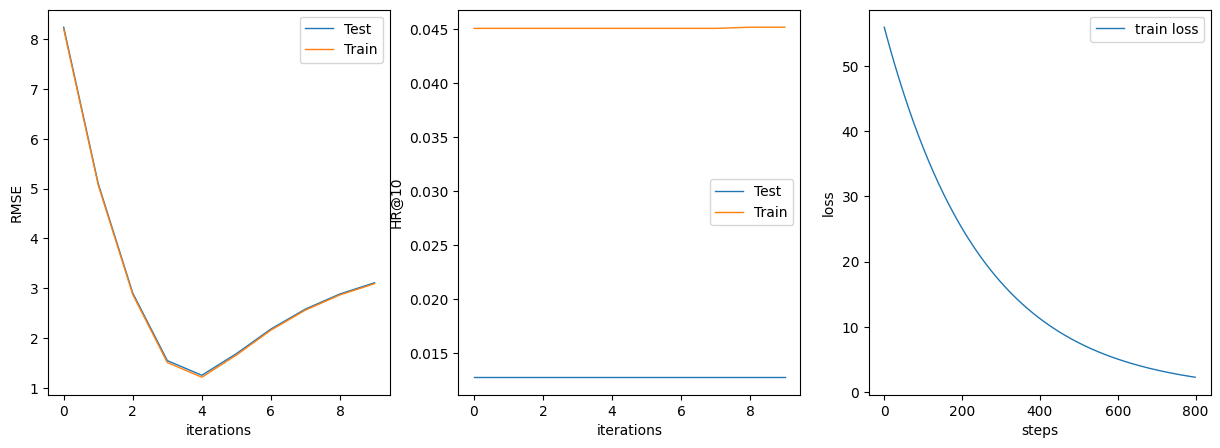

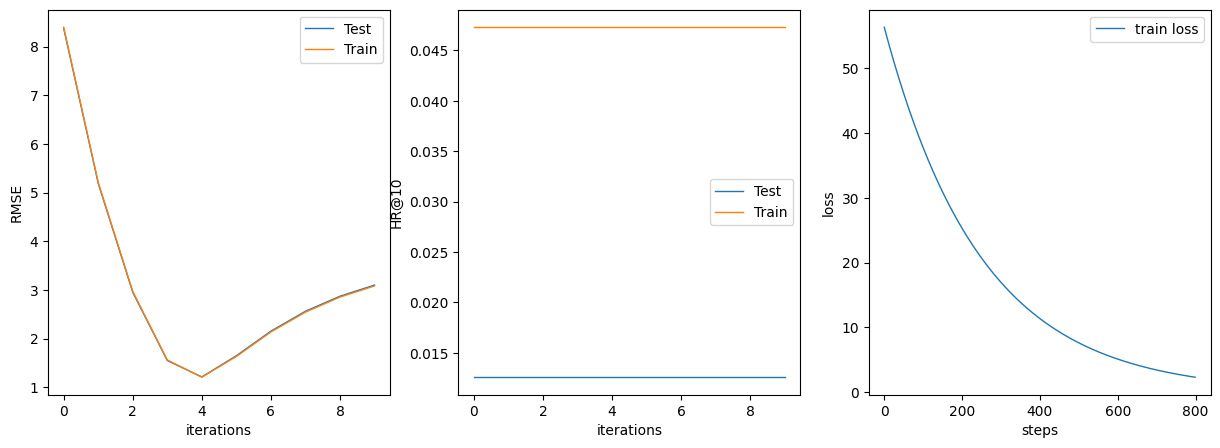

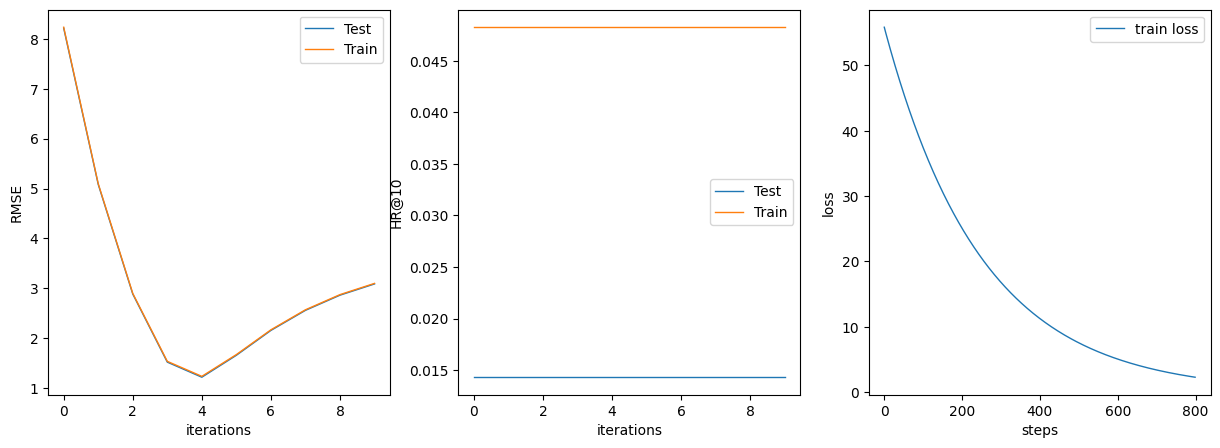

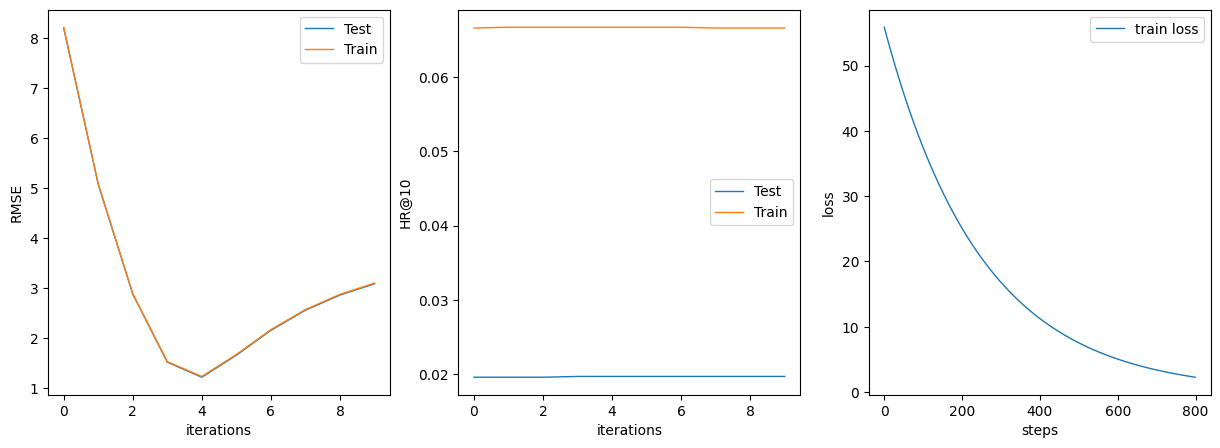

In [12]:
for fold in range(1,5):
    # removed 5th fold because it was causing errors,
    # the data for users was zeros and tables created during training were smaller than they should
    # inputing data would be bad practice, and there does not seem to be a way to do it properly
    train = pd.read_csv('ml-100k/u{}.base'.format(fold), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                             delim_whitespace=True)
    test = pd.read_csv('ml-100k/u{}.test'.format(fold), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                             delim_whitespace=True)
    
    #YOUR TASK: get train and test R, fit the model, plot learning curve
    train = np.array(pd.crosstab(index=pd.Categorical(train['user_id'],categories = [i for i in range(1,943+1)]), 
                                                    columns=pd.Categorical(train['item_id'],categories = [i for i in range(1,1682+1)]),
                                                    values=train['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
    test = np.array(pd.crosstab(index=pd.Categorical(test['user_id'],categories = [i for i in range(1,943+1)]), 
                                                    columns=pd.Categorical(test['item_id'],categories = [i for i in range(1,1682+1)]),
                                                    values=test['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
    als = MF_ALS_Batched(n_iters = 10, n_factors = 64, reg = 0.001)
    als.fit(train,test,lr=1,BS=1000)
    plot_learning_curve(als)

In [13]:
#Searching for the best factor and reg using some simple grid search around the proposed values.
results = []
for factor in [16, 32, 64]:
    print(factor)
    for re in [0.005, 0.001, 0.0005, 0.0001]:
        print(re)
        hr = 0
        rms = 0
        for fold in range(1,5):
            # removed 5th fold because it was causing errors,
            # the data for users was zeros and tables created during training were smaller than they should
            # inputing data would be bad practice, and there does not seem to be a way to do it properly
            train = pd.read_csv('ml-100k/u{}.base'.format(fold), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                                     delim_whitespace=True)
            test = pd.read_csv('ml-100k/u{}.test'.format(fold), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                                     delim_whitespace=True)

            #YOUR TASK: get train and test R, fit the model, plot learning curve
            train = np.array(pd.crosstab(index=pd.Categorical(train['user_id'],categories = [i for i in range(1,943+1)]), 
                                                            columns=pd.Categorical(train['item_id'],categories = [i for i in range(1,1682+1)]),
                                                            values=train['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
            test = np.array(pd.crosstab(index=pd.Categorical(test['user_id'],categories = [i for i in range(1,943+1)]), 
                                                            columns=pd.Categorical(test['item_id'],categories = [i for i in range(1,1682+1)]),
                                                            values=test['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)

            als = MF_ALS_Batched(n_iters = 10, n_factors = factor, reg = re)
            als.fit(train,test,lr=1,BS=1000)
            hr += als.test_hr[-1]
            rms += als.test_rmse_record[-1]
            
        results.append([factor, re, hr / 4, rms / 4])
print(results)

16
0.005
0.001
0.0005
0.0001
32
0.005
0.001
0.0005
0.0001
64
0.005
0.001
0.0005
0.0001
[[16, 0.005, 0.016243119729333927, 3.70710912999265], [16, 0.001, 0.016275206618525787, 3.5524250983059833], [16, 0.0005, 0.013040006564661899, 2.945479532199783], [16, 0.0001, 0.011203058459156007, 1.4396815433789132], [32, 0.005, 0.013434727903179632, 3.707108740108578], [32, 0.001, 0.013577698665185389, 3.4010634014988157], [32, 0.0005, 0.014143479944116192, 2.231438983961511], [32, 0.0001, 0.014215333535322915, 2.682401724187063], [64, 0.005, 0.01419124206770016, 3.707107951249279], [64, 0.001, 0.01539939234796073, 3.0937143421728024], [64, 0.0005, 0.015663977680149453, 1.217535283682483], [64, 0.0001, 0.01689369455806357, 8.272193433637336]]


Attempt to make readout easier

In [15]:
collected = np.array(results)
print("Max hit rate for hyperparams:")
print(collected[np.argmax(collected[:, 2])])
print("Min RMSE for hyperparams::")
print(collected[np.argmin(collected[:, 3])])

Max hit rate for hyperparams:
[6.40000000e+01 1.00000000e-04 1.68936946e-02 8.27219343e+00]
Min RMSE for hyperparams::
[6.40000000e+01 5.00000000e-04 1.56639777e-02 1.21753528e+00]


According to these results its impossible to parametrize this algorithm to maximize both hit rate and RMSE.
Therefore we should consult an expert or other person familiar with the matter to decide which of them more important in our case

If we assume that hit rate is the most important then we should use parameters factor 64 and re 0.0001

If we assume that RMSE is the most important then we should use parameters factor 64 and re 0.0005

#### 6. How to modify the above code so that:

We would have ratings {0,1} only instead of {1,2,3,4,5}. What will it change?